## House Price Prediction

### Import required packages

In [67]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import Lasso, LassoCV
from scipy.stats import skew
from scipy.special import boxcox1p


### Read the training data

In [68]:
train=pd.read_csv('train.csv')

In [69]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Checking for null values and unique values

In [70]:
for (name, series) in train.iteritems():
    if sum(train[name].isnull().values.ravel()) > 0:
        print('\n'+'ANALYZED VARIABLE NAME:', name)
        #counting records
        print("-- COUNT OF MISSING VALUES:", sum(train[name].isnull().values.ravel()))
        #counting ratio
        print("-- RATIO OF MISSING VALUES:", round(((sum(train[name].isnull().values.ravel()) / train[name].size)*100),2),'%')
        #counting unique value
        print("-- COUNT OF UNIQUE VALUE (CARDINALITY):", train[name].unique().size)


ANALYZED VARIABLE NAME: LotFrontage
-- COUNT OF MISSING VALUES: 259
-- RATIO OF MISSING VALUES: 17.74 %
-- COUNT OF UNIQUE VALUE (CARDINALITY): 111

ANALYZED VARIABLE NAME: Alley
-- COUNT OF MISSING VALUES: 1369
-- RATIO OF MISSING VALUES: 93.77 %
-- COUNT OF UNIQUE VALUE (CARDINALITY): 3

ANALYZED VARIABLE NAME: MasVnrType
-- COUNT OF MISSING VALUES: 8
-- RATIO OF MISSING VALUES: 0.55 %
-- COUNT OF UNIQUE VALUE (CARDINALITY): 5

ANALYZED VARIABLE NAME: MasVnrArea
-- COUNT OF MISSING VALUES: 8
-- RATIO OF MISSING VALUES: 0.55 %
-- COUNT OF UNIQUE VALUE (CARDINALITY): 328

ANALYZED VARIABLE NAME: BsmtQual
-- COUNT OF MISSING VALUES: 37
-- RATIO OF MISSING VALUES: 2.53 %
-- COUNT OF UNIQUE VALUE (CARDINALITY): 5

ANALYZED VARIABLE NAME: BsmtCond
-- COUNT OF MISSING VALUES: 37
-- RATIO OF MISSING VALUES: 2.53 %
-- COUNT OF UNIQUE VALUE (CARDINALITY): 5

ANALYZED VARIABLE NAME: BsmtExposure
-- COUNT OF MISSING VALUES: 38
-- RATIO OF MISSING VALUES: 2.6 %
-- COUNT OF UNIQUE VALUE (CARDINAL

### Filling the NA values in some columns with respective meanings taken from dictionary provided

In [71]:
# For the 14 columns with "NA" that actually has a meaning, repalce "NA" with the actual meaning

train.fillna(
    {'Alley':'No alley access', 
     'BsmtQual':'No Basement', 
     'BsmtCond':'No Basement', 
     'BsmtExposure':'No Basement', 
     'BsmtFinType1':'No Basement', 
     'BsmtFinType2':'No Basement',
     'FireplaceQu':'No Fireplace',
     'GarageType':'No Garage',
     'GarageFinish':'No Garage',
     'GarageQual':'No Garage',
     'GarageCond':'No Garage',
     'PoolQC':'No Pool',
     'Fence':'No Fence',
     'MiscFeature':'None',}, inplace=True)

In [72]:
dict(train.isna().sum())

{'Id': 0,
 'MSSubClass': 0,
 'MSZoning': 0,
 'LotFrontage': 259,
 'LotArea': 0,
 'Street': 0,
 'Alley': 0,
 'LotShape': 0,
 'LandContour': 0,
 'Utilities': 0,
 'LotConfig': 0,
 'LandSlope': 0,
 'Neighborhood': 0,
 'Condition1': 0,
 'Condition2': 0,
 'BldgType': 0,
 'HouseStyle': 0,
 'OverallQual': 0,
 'OverallCond': 0,
 'YearBuilt': 0,
 'YearRemodAdd': 0,
 'RoofStyle': 0,
 'RoofMatl': 0,
 'Exterior1st': 0,
 'Exterior2nd': 0,
 'MasVnrType': 8,
 'MasVnrArea': 8,
 'ExterQual': 0,
 'ExterCond': 0,
 'Foundation': 0,
 'BsmtQual': 0,
 'BsmtCond': 0,
 'BsmtExposure': 0,
 'BsmtFinType1': 0,
 'BsmtFinSF1': 0,
 'BsmtFinType2': 0,
 'BsmtFinSF2': 0,
 'BsmtUnfSF': 0,
 'TotalBsmtSF': 0,
 'Heating': 0,
 'HeatingQC': 0,
 'CentralAir': 0,
 'Electrical': 1,
 '1stFlrSF': 0,
 '2ndFlrSF': 0,
 'LowQualFinSF': 0,
 'GrLivArea': 0,
 'BsmtFullBath': 0,
 'BsmtHalfBath': 0,
 'FullBath': 0,
 'HalfBath': 0,
 'BedroomAbvGr': 0,
 'KitchenAbvGr': 0,
 'KitchenQual': 0,
 'TotRmsAbvGrd': 0,
 'Functional': 0,
 'Fireplaces'

### Impute with mean for 2 numerical variables

In [73]:
train['LotFrontage']=train['LotFrontage'].fillna(round(train['LotFrontage'].mean()))
train['MasVnrArea']=train['MasVnrArea'].fillna(round(train['MasVnrArea'].mean()))

### Impute with value which occured most frequently for the remaining 3 categorical variables

In [74]:
train = train.apply(lambda x: x.fillna(x.value_counts().index[0]))

### Remove unncessary columns

In [75]:
train=train.drop(columns=['Id'])

### Find outliers

In [76]:
df=train.select_dtypes(np.number)

In [77]:
df.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [78]:
## Select the columns from the above list which seem to have data outside bounds
columns = ['MSSubClass', 'LotFrontage', 'LotArea','BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF']
outlier_index=[]
for col in columns:
    z = np.abs(stats.zscore(train[col]))
    threshold = 3
    outlier_index.append(list(np.where(z > threshold)[0]))

In [79]:
final_list = []
for i in outlier_index:
    final_list = final_list+i

In [80]:
final_list= set(final_list)

In [81]:
for element in final_list:
    train = train[train.index!=element]

### Create a target variable for Sale Price

In [82]:
train['SalePrice']=np.log(train['SalePrice'])

In [83]:
y=train['SalePrice']

In [84]:
x=train.drop(columns=['SalePrice'])

### Final shape of input

In [85]:
x.shape

(1382, 79)

### Feature Selection 

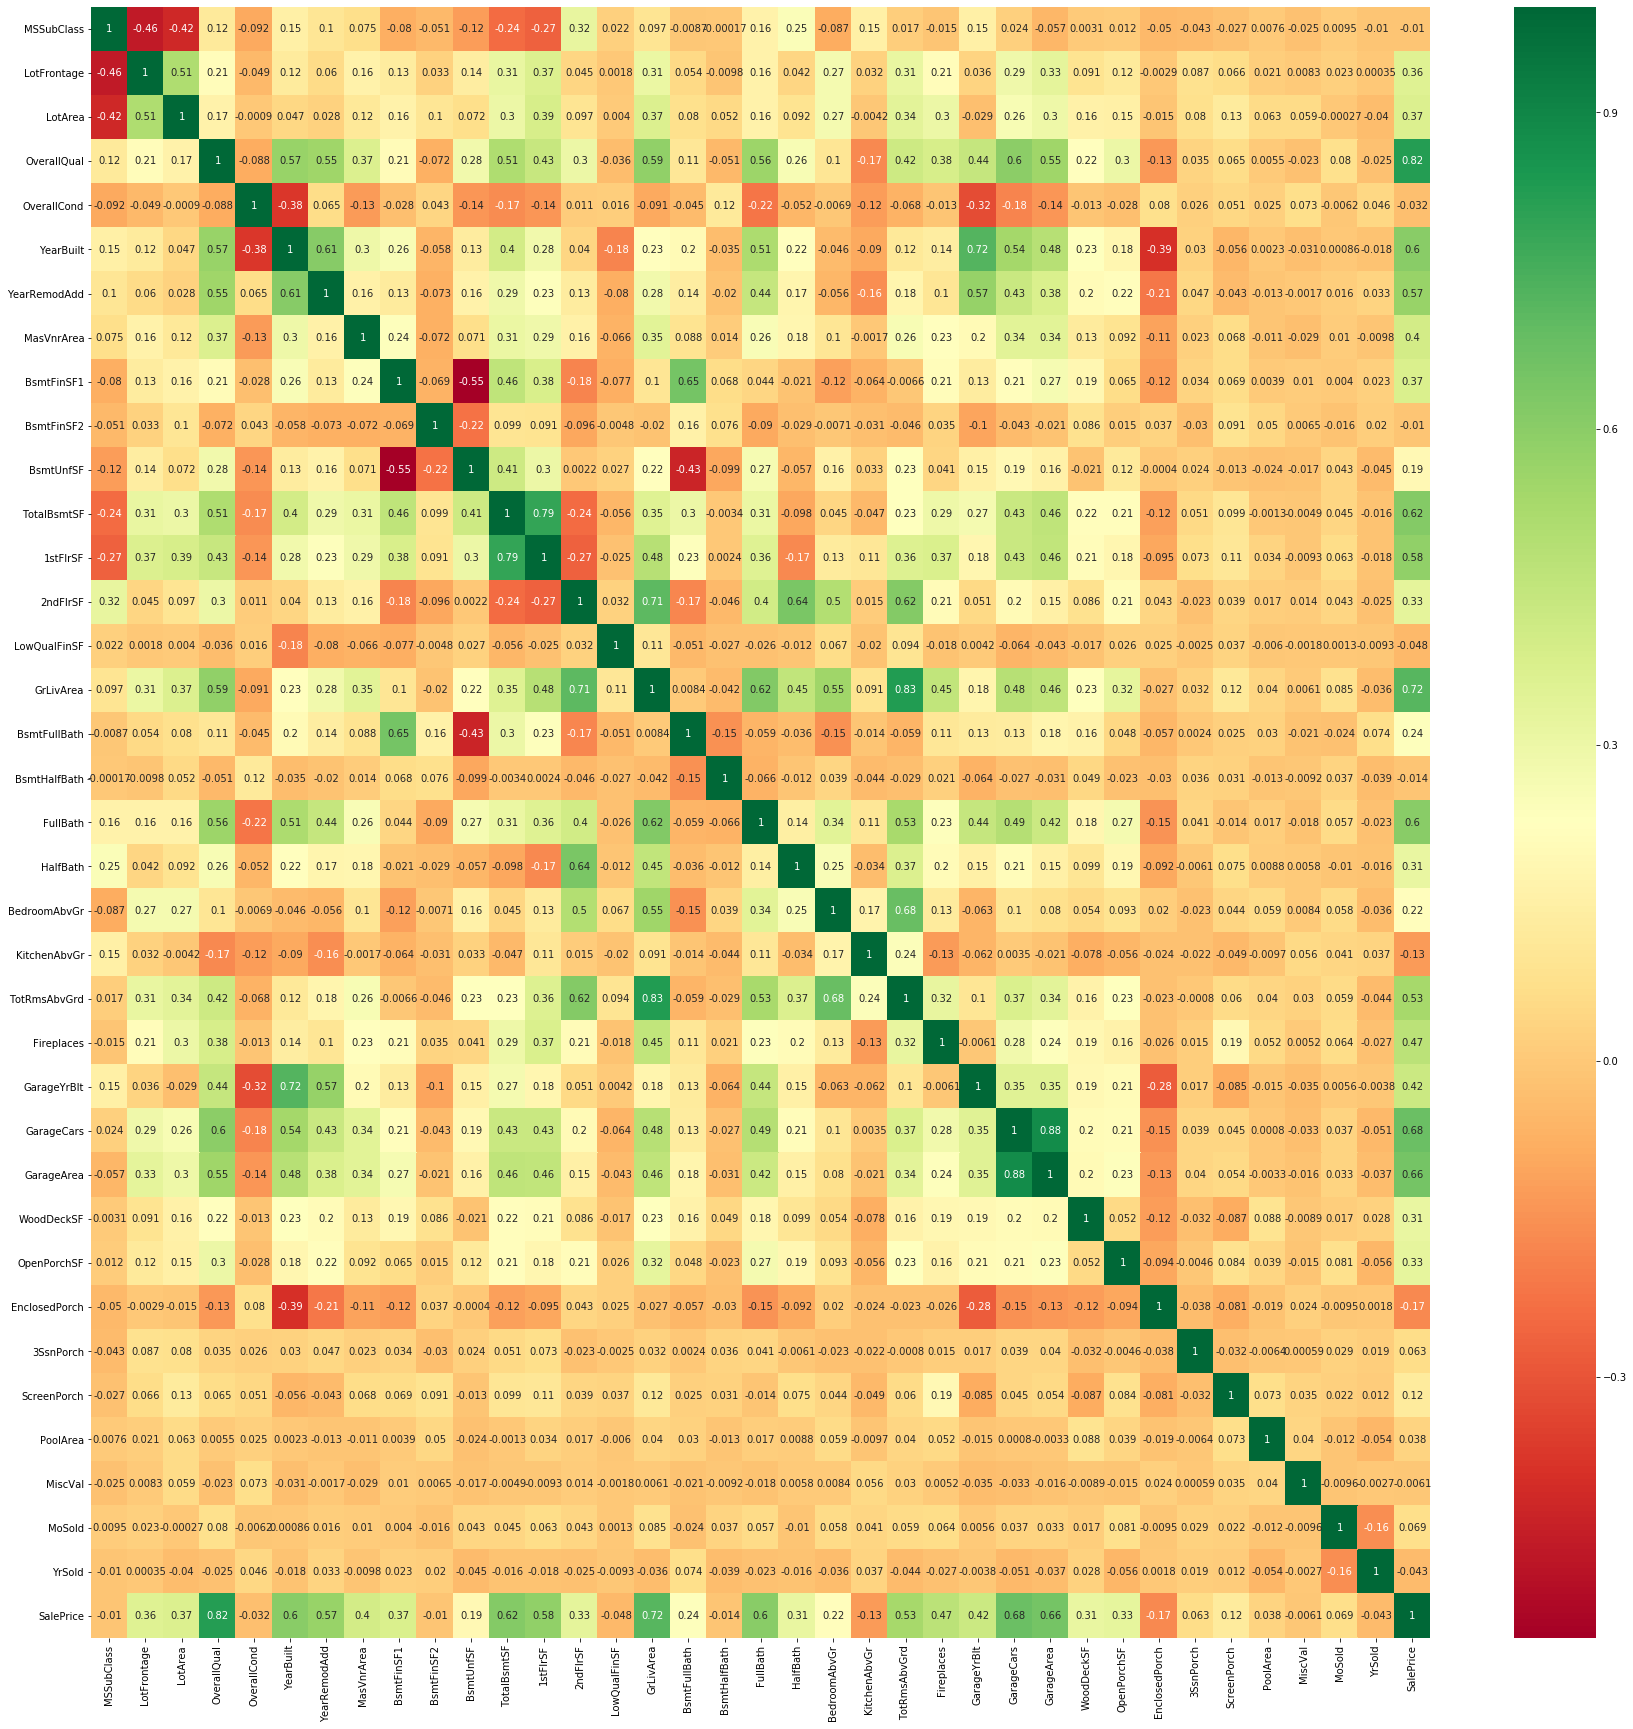

In [86]:
corrmat = train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(30,30))
#plot heat map
g=sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [87]:

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
sol = (corrmat.where(np.triu(np.ones(corrmat.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))

In [88]:
sol[sol>0.5]

GarageCars    GarageArea      0.881780
GrLivArea     TotRmsAbvGrd    0.828644
OverallQual   SalePrice       0.818671
TotalBsmtSF   1stFlrSF        0.790170
YearBuilt     GarageYrBlt     0.722854
GrLivArea     SalePrice       0.719207
2ndFlrSF      GrLivArea       0.708770
BedroomAbvGr  TotRmsAbvGrd    0.684251
GarageCars    SalePrice       0.677400
GarageArea    SalePrice       0.655295
BsmtFinSF1    BsmtFullBath    0.649898
2ndFlrSF      HalfBath        0.640894
GrLivArea     FullBath        0.622402
2ndFlrSF      TotRmsAbvGrd    0.619026
TotalBsmtSF   SalePrice       0.615136
YearBuilt     YearRemodAdd    0.608790
FullBath      SalePrice       0.602491
YearBuilt     SalePrice       0.601723
OverallQual   GarageCars      0.595757
              GrLivArea       0.586251
1stFlrSF      SalePrice       0.584430
YearRemodAdd  GarageYrBlt     0.573483
              SalePrice       0.570719
OverallQual   YearBuilt       0.569984
              FullBath        0.557916
              YearRemodAd

In [89]:
#for each of 2 features which are highly correlated, removing the less correlated with SalePrice
x.drop(['GarageArea','1stFlrSF','TotRmsAbvGrd','2ndFlrSF'], axis=1, inplace=True)


### Read test data

In [90]:
test=pd.read_csv('test.csv')

In [91]:
test.drop(['GarageArea','1stFlrSF','TotRmsAbvGrd','2ndFlrSF'], axis=1, inplace=True)

### Checking for null values in test data

In [92]:
for (name, series) in test.iteritems():
    if sum(test[name].isnull().values.ravel()) > 0:
        print('\n'+'ANALYZED VARIABLE NAME:', name)
        #counting records
        print("-- COUNT OF MISSING VALUES:", sum(test[name].isnull().values.ravel()))
        #counting ratio
        print("-- RATIO OF MISSING VALUES:", round(((sum(test[name].isnull().values.ravel()) / test[name].size)*100),2),'%')
        #counting unique value
        print("-- COUNT OF UNIQUE VALUE (CARDINALITY):", test[name].unique().size)


ANALYZED VARIABLE NAME: MSZoning
-- COUNT OF MISSING VALUES: 4
-- RATIO OF MISSING VALUES: 0.27 %
-- COUNT OF UNIQUE VALUE (CARDINALITY): 6

ANALYZED VARIABLE NAME: LotFrontage
-- COUNT OF MISSING VALUES: 227
-- RATIO OF MISSING VALUES: 15.56 %
-- COUNT OF UNIQUE VALUE (CARDINALITY): 116

ANALYZED VARIABLE NAME: Alley
-- COUNT OF MISSING VALUES: 1352
-- RATIO OF MISSING VALUES: 92.67 %
-- COUNT OF UNIQUE VALUE (CARDINALITY): 3

ANALYZED VARIABLE NAME: Utilities
-- COUNT OF MISSING VALUES: 2
-- RATIO OF MISSING VALUES: 0.14 %
-- COUNT OF UNIQUE VALUE (CARDINALITY): 2

ANALYZED VARIABLE NAME: Exterior1st
-- COUNT OF MISSING VALUES: 1
-- RATIO OF MISSING VALUES: 0.07 %
-- COUNT OF UNIQUE VALUE (CARDINALITY): 14

ANALYZED VARIABLE NAME: Exterior2nd
-- COUNT OF MISSING VALUES: 1
-- RATIO OF MISSING VALUES: 0.07 %
-- COUNT OF UNIQUE VALUE (CARDINALITY): 16

ANALYZED VARIABLE NAME: MasVnrType
-- COUNT OF MISSING VALUES: 16
-- RATIO OF MISSING VALUES: 1.1 %
-- COUNT OF UNIQUE VALUE (CARDINALI

### Filling the NA values in some columns with respective meanings taken from dictionary provided

In [93]:

test.fillna(
    {'Alley':'No alley access', 
     'BsmtQual':'No Basement', 
     'BsmtCond':'No Basement', 
     'BsmtExposure':'No Basement', 
     'BsmtFinType1':'No Basement', 
     'BsmtFinType2':'No Basement',
     'FireplaceQu':'No Fireplace',
     'GarageType':'No Garage',
     'GarageFinish':'No Garage',
     'GarageQual':'No Garage',
     'GarageCond':'No Garage',
     'PoolQC':'No Pool',
     'Fence':'No Fence',
     'MiscFeature':'None',}, inplace=True)

### Impute with mean for 7 numerical variables

In [94]:
test['LotFrontage'] = test['LotFrontage'].fillna(round(train['LotFrontage'].mean()))
test['MasVnrArea'] = test['MasVnrArea'].fillna(round(train['MasVnrArea'].mean()))
test['BsmtFinSF1'] = test['BsmtFinSF1'].fillna(round(train['BsmtFinSF1'].mean()))
test['BsmtFinSF2'] = test['BsmtFinSF2'].fillna(round(train['BsmtFinSF2'].mean()))
test['BsmtUnfSF'] = test['BsmtUnfSF'].fillna(round(train['BsmtUnfSF'].mean()))
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(round(train['TotalBsmtSF'].mean()))


### Impute with value which occured most frequently for the remaining 12 categorical variables

In [95]:
columns = dict(test.isna().sum())

In [96]:
null_columns = {}
for column in columns:
    if columns[column]>0:
        null_columns[column] = columns[column]

In [97]:
null_columns

{'MSZoning': 4,
 'Utilities': 2,
 'Exterior1st': 1,
 'Exterior2nd': 1,
 'MasVnrType': 16,
 'BsmtFullBath': 2,
 'BsmtHalfBath': 2,
 'KitchenQual': 1,
 'Functional': 2,
 'GarageYrBlt': 78,
 'GarageCars': 1,
 'SaleType': 1}

In [98]:
for column in null_columns:
    test[column]=test[column].fillna(train[column].mode()[0])

### Remove unnecessary columns

In [99]:
ids=test['Id']

In [100]:
test = test.drop(columns=['Id'])

### Final shape of test data

In [101]:
test.shape

(1459, 75)

### Combine train and test to prepare for removing skewness

In [102]:
combined = pd.concat([x,test],axis=0,sort = False)

### The column MSSubClass has to be changed from numerical to categorical

In [103]:
combined['MSSubClass']=combined['MSSubClass'].astype(str)

### Select the variables which have skewness

In [104]:
skew=combined.select_dtypes(include=['int','float']).apply(lambda x: skew(x)).sort_values(ascending=False)
skew_df=pd.DataFrame({'Skew':skew})
skewed_df=skew_df[(skew_df['Skew']>0.5)|(skew_df['Skew']<-0.5)]

In [105]:
skew_df

,Skew
MiscVal,22.022239
PoolArea,19.582953
LowQualFinSF,12.982192
3SsnPorch,11.219611
KitchenAbvGr,4.509275
BsmtFinSF2,4.171653
EnclosedPorch,4.021497
ScreenPorch,3.949193
BsmtHalfBath,3.926911
LotArea,2.599617


In [106]:
skewed_df.index

Index(['MiscVal', 'PoolArea', 'LowQualFinSF', '3SsnPorch', 'KitchenAbvGr',
       'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch', 'BsmtHalfBath', 'LotArea',
       'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'BsmtFinSF1', 'GrLivArea',
       'BsmtUnfSF', 'Fireplaces', 'HalfBath', 'BsmtFullBath', 'TotalBsmtSF',
       'OverallCond', 'YearBuilt'],
      dtype='object')

### Separate the train and test to transform

In [107]:
train = combined[:1382]
test = combined[1382:]

### Transform the train and set such that all variables are normally distributed to ensure that our model runs well

In [108]:
lam=0.3
for col in skewed_df.index:
    train[col]=boxcox1p(train[col],lam)
    test[col]=boxcox1p(test[col],lam)

/Users/akhila/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/akhila/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### Combine the train and test to perform encoding

In [109]:
combined = pd.concat([train,test],axis=0,sort = False)

### Shape of the combined table

In [110]:
combined.shape

(2841, 75)

### Perform one-hot encoding for the combined data

In [111]:
encoded_xy = pd.get_dummies(combined)

In [112]:
encoded_xy.shape

(2841, 312)

### Separate the data back to train and test, to train the model

In [113]:
encoded_x = encoded_xy[:1382]
encoded_x

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,46.895279,7,2.372566,29.283971,2003,12.930339,20.528542,0.000000,11.683274,...,0,0,0,1,0,0,0,0,1,0
1,80.0,48.855031,6,3.110607,29.151508,1976,0.000000,22.976225,0.000000,14.835716,...,0,0,0,1,0,0,0,0,1,0
2,68.0,51.398007,7,2.372566,29.274202,2002,12.031754,18.003867,0.000000,17.293166,...,0,0,0,1,0,0,0,0,1,0
3,60.0,48.773346,7,2.372566,28.847508,1970,0.000000,13.409026,0.000000,18.687712,...,0,0,0,1,1,0,0,0,0,0
4,84.0,55.432343,8,2.372566,29.269314,2000,16.007308,19.998555,0.000000,18.056293,...,0,0,0,1,0,0,0,0,1,0
5,85.0,55.252450,5,2.372566,29.235057,1995,0.000000,20.788479,0.000000,8.328122,...,0,0,0,1,0,0,0,0,1,0
6,75.0,49.630757,8,2.372566,29.288853,2005,12.678137,25.766796,0.000000,15.442831,...,0,0,0,1,0,0,0,0,1,0
7,70.0,50.095489,7,2.642633,29.136712,1973,13.944284,21.972945,6.182195,13.409026,...,0,0,0,1,0,0,0,0,1,0
8,51.0,42.262532,7,2.372566,28.927894,1950,0.000000,0.000000,0.000000,22.764630,...,0,0,0,1,1,0,0,0,0,0
10,70.0,51.324924,5,2.372566,29.097178,1965,0.000000,22.380151,0.000000,11.187077,...,0,0,0,1,0,0,0,0,1,0


In [114]:
predictors = encoded_x.columns

In [115]:
encoded_test = encoded_xy[1382:]

### Scaling

In [116]:
sc=RobustScaler()
encoded_x=sc.fit_transform(encoded_x)
encoded_test=sc.transform(encoded_test)

### Fit Random forest regressor to our training data

In [117]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [118]:
rf.fit(encoded_x, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

### Predict the Sale Price for test data using the trained model

In [119]:
predictions = rf.predict(encoded_test)
preds=np.exp(predictions)
test['predicted']=preds
test['Id']=ids
submission = test[['Id','predicted']]


In [120]:
eva = pd.merge(submission, test_actual, on='Id', how='inner')

### MAPE value for RF model

In [121]:
np.mean(100*abs(eva['predicted']-eva['SalePrice'])/eva['SalePrice'])

9.72766370670647

### Fit LASSO model

In [122]:
model=Lasso(alpha =0.0005, random_state=42)
model.fit(encoded_x,y)

Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)

In [123]:
eva.head()

,Id,predicted,SalePrice
0,1461,123835.327442,105000
1,1462,153652.346132,172000
2,1463,177233.649649,189900
3,1464,183646.005257,195500
4,1465,193844.093114,191500


### Predict House prices for test set

In [124]:
predictions = model.predict(encoded_test)
preds=np.exp(predictions)
test['predicted']=preds
test['Id']=ids
submission = test[['Id','predicted']]
eva = pd.merge(submission, test_actual, on='Id', how='inner')

### MAPE value for LASSO model

In [125]:
np.mean(100*abs(eva['predicted']-eva['SalePrice'])/eva['SalePrice'])

8.164773544670725